In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
#importing necessary libraries
import numpy as np
import pandas as pd 
import torch
from torch import optim
import torch.nn as nn

import cv2
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as a_s
import os 
from torchsummary import summary
import zipfile

In [3]:
df = pd.read_csv('../input/chinese-mnist/chinese_mnist.csv',sep=',')

In [4]:
#take a look at it
df# image file names include some info about the image like suite_id sample id and code.
#if we can add value as a label for our custom dataset that will be good.

df.isnull().sum(),df.shape #there is no missing vals and number of data and number of images are match up

df.info()#we need to encode df character. we can use get dummies 

X = df.drop('character', axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   15000 non-null  int64 
 1   sample_id  15000 non-null  int64 
 2   code       15000 non-null  int64 
 3   value      15000 non-null  int64 
 4   character  15000 non-null  object
dtypes: int64(4), object(1)
memory usage: 586.1+ KB


In [5]:
class CustomDataset(Dataset):
  def __init__(self, k,l, csv_file ='../input/chinese-mnist/chinese_mnist.csv'):


    self.df = pd.read_csv(csv_file)
    

    self.k= {'九':int(9),'十':int(10),'百':int(11),'千':int(12),'万':int(13),'亿':int(14),'零':int(0),'一':int(1),'二':int(2),'三':int(3),'四':int(4),'五':int(5),'六':int(6),'七':int(7),'八':int(8)}

    


    self.target = 'character'
    self.features = ['suite_id','sample_id','code',]

    #self.categorical = 'value'

    #self.cat = pd.get_dummies(df, prefix=self.categorical)

    self.labels   = np.asarray(self.df.iloc[:, 4])
    
    self.y = df[self.target]
    self.X = df.drop(self.target, axis =1 )

  def __getitem__(self,idx):

    single_image_label = self.labels[idx]

    class_id = self.k[single_image_label]
    
    img = Image.open(f"../input/chinese-mnist/data/data/input_{self.X.iloc[idx, 0]}_{self.X.iloc[idx, 1]}_{self.X.iloc[idx, 2]}.jpg")
    img = np.array(img) # convert to np.array
       

    return img, class_id

  def __len__(self):

    return len(self.X)


In [6]:
train_df = df.groupby('value').apply(lambda x: x.sample(700, random_state=42)).reset_index(drop=True)
x_train, y_train  = train_df.iloc[:, :-2], train_df.iloc[:, -2]

test_df  = df.groupby('value').apply(lambda x: x.sample(300, random_state=42)).reset_index(drop=True)
x_test, y_test    = test_df.iloc[:, :-2], test_df.iloc[:, -2]

#create train dataset and test dataset 
train_ds = CustomDataset(x_train, y_train)
trainloader = DataLoader(dataset=train_ds,batch_size=32, shuffle=True)

test_ds = CustomDataset(x_test, y_test)
testloader = DataLoader(test_ds, batch_size=32, shuffle=True)

'八'

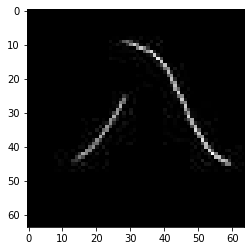

In [7]:
dictt = {int(9):'九',int(10):'十',int(11):'百',
  int(12):'千',int(13):'万',int(14):'亿',
  int(0):'零',int(1):'一',int(2):'二',
  int(3):'三',int(4):'四',int(5):'五',
  int(6):'六',int(7):'七',int(8):'八'}

dataiter = iter(testloader)
images,labels = dataiter.next()
plt.imshow(images[0], cmap='gray')#
dictt[int(labels[0])]

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        
        self.fc1 = nn.Linear(64*13*13, 500)
        self.fc2 = nn.Linear(500, 15)

        self.log_softmax = nn.LogSoftmax(dim=0)
        self.conv2_drop = nn.Dropout2d()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        output = self.log_softmax(x)
        return output

model = Net()

In [9]:

#summary(model,(64,64))

los = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001,)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
#optimizer = optim.SGD(model.parameters(),lr = 0.001,momentum=1)

In [10]:
epochs = 5
#learning_rate = 0.001
#decay_rate = learning_rate / epochs
#optimizer = optim.Adagrad(model.parameters(),lr = learning_rate)
print_every = 96

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # turn it to float and resize
        
        images = images.resize_(images.size()[0], 64,64).float()
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        losss = los(output, labels)     # 2) Compute loss
        losss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += losss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/len(trainloader):.3f}")
            running_loss = 0

Epoch: 1/5
	Iteration: 0	 Loss: 0.008
	Iteration: 96	 Loss: 0.438
	Iteration: 192	 Loss: 0.259
	Iteration: 288	 Loss: 0.195
	Iteration: 384	 Loss: 0.165
Epoch: 2/5
	Iteration: 0	 Loss: 0.001
	Iteration: 96	 Loss: 0.125
	Iteration: 192	 Loss: 0.113
	Iteration: 288	 Loss: 0.109
	Iteration: 384	 Loss: 0.107
Epoch: 3/5
	Iteration: 0	 Loss: 0.001
	Iteration: 96	 Loss: 0.079
	Iteration: 192	 Loss: 0.087
	Iteration: 288	 Loss: 0.078
	Iteration: 384	 Loss: 0.074
Epoch: 4/5
	Iteration: 0	 Loss: 0.001
	Iteration: 96	 Loss: 0.068
	Iteration: 192	 Loss: 0.074
	Iteration: 288	 Loss: 0.071
	Iteration: 384	 Loss: 0.073
Epoch: 5/5
	Iteration: 0	 Loss: 0.001
	Iteration: 96	 Loss: 0.059
	Iteration: 192	 Loss: 0.062
	Iteration: 288	 Loss: 0.058
	Iteration: 384	 Loss: 0.060


In [11]:
test_size = len(test_ds)
train_size = len(train_ds)
r_labels = np.array([])
preds  = np.array([])

correct_preds = np.array([])


for i, (images, labels) in enumerate(iter(testloader)):
  model.eval()

  # turn it to float and resize
    
  images = images.resize_(images.size()[0], 64,64).float()

  outputs = model(images)

  loss = los(outputs, labels)



  r_labels = np.concatenate((r_labels, labels.numpy()))


  for index, item in enumerate(outputs):
      if r_labels[index] == torch.argmax(item):
          correct_preds += 1

      preds  = np.concatenate((preds, torch.argmax(item).unsqueeze(-1).detach().numpy()))


conf_mat = confusion_matrix(r_labels, preds)


accuracy_scores= a_s(r_labels, preds)

print(f'Test results with respect to confusion matrix: \n{conf_mat} \nand the accuracy score is : \n {accuracy_scores}')
# it 92% so far

Test results with respect to confusion matrix: 
[[972   1   0   1   2   1   2   0   1   4   1   5   3   5   2]
 [  0 977  17   0   0   0   0   1   0   0   2   0   0   3   0]
 [  0  12 942  41   0   1   0   2   0   1   0   0   0   1   0]
 [  1   3  42 946   0   4   0   2   0   0   2   0   0   0   0]
 [  2   2   1   1 945   5   2   2   3   2   3  22   0   6   4]
 [  2   0   7  22   2 952   2   1   1   1   2   5   0   0   3]
 [  6   7   7  11   2   0 919   2   9   2   9   2   5  18   1]
 [  2   1   8   3   3   1   2 951   0   8   6   3   3   1   8]
 [  0   1   1   0   1   0   1   0 982   2   5   1   2   1   3]
 [  0   1   0   3   2   8   7  19  18 902   8   2   2   6  22]
 [  2   2   3   0   2   0   5   2   2   3 925   1  47   6   0]
 [  4   1   2   1  15   9   2   3   7   1   5 933   2  14   1]
 [  0   1   4   3   1   3   7   5   1   0  20   3 945   6   1]
 [  5   3   0   1   1   1   4   1   1   2   3  30   1 944   3]
 [  2   3   2   1   2   3   2   3   7  16   3   1   1   4 950]] 
and t

In [12]:
dictt = {int(9):'九',int(10):'十',int(11):'百',
  int(12):'千',int(13):'万',int(14):'亿',
  int(0):'零',int(1):'一',int(2):'二',
  int(3):'三',int(4):'四',int(5):'五',
  int(6):'六',int(7):'七',int(8):'八'}

In [13]:
for i,(images,labels) in enumerate(iter(testloader)):
    
  with torch.no_grad():

    images = images.resize_(images.size()[0], 64,64).float()
    output = model(images)

五


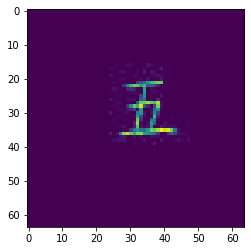

In [14]:
plt.imshow(images[7,:,:])
print(dictt[output[7,:].argmax().item()])